In [2]:
# ===================== AASIST-Lite FAST + NOTEBOOK-SAFE (FULL TRAIN+EVAL) =====================
# Fixes "1st epoch not starting" on Windows/Jupyter by using NUM_WORKERS=0 and no persistent workers.
# Also adds an explicit cache-build step with progress so you can see it working.

import os, random, hashlib, time
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from tqdm import tqdm

# ---------------- CONFIG ----------------
DATASET_ROOT = r"D:\RealVsTelephone_Split"
SAMPLE_RATE  = 16000

# Feature sizes
N_MELS       = 64
N_LINFB      = 64
N_FFT        = 1024
HOP_LENGTH   = 256
MAX_FRAMES   = 256

# Training
BATCH_SIZE   = 16
EPOCHS       = 30
LR           = 2e-4
RANDOM_SEED  = 42

# NOTEBOOK SAFE DATALOADER (prevents hang)
NUM_WORKERS = 0
PIN_MEMORY = True

# SpecAugment
USE_SPECAUG      = True
TIME_MASK_PARAM  = 24
FREQ_MASK_PARAM  = 6
SPECAUG_PROB     = 0.8

# Audio safety
MIN_AUDIO_SAMPLES = 2048
MIN_RMS = 1e-4
DO_TRIM = True
TRIM_TOP_DB = 30

# Feature cache (big speed gain after build)
CACHE_FEATURES_TO_DISK = True
CACHE_DIR = os.path.join(DATASET_ROOT, "_feat_cache_mel_lfb_fast")
CACHE_TRAIN_TOO = True  # also cache train for fastest epochs

# Model size (faster)
D_MODEL = 192
N_HEAD = 4
N_LAYERS = 1
DROPOUT = 0.2

# AMP
USE_AMP = True

# ---------------- REPRO ----------------
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if device.type == "cuda":
    torch.backends.cudnn.benchmark = True

# ---------------- CLASS NAMES ----------------
train_base = os.path.join(DATASET_ROOT, "train")
CLASS_NAMES = sorted([d for d in os.listdir(train_base) if os.path.isdir(os.path.join(train_base, d))])
NUM_CLASSES = len(CLASS_NAMES)
print("Classes:", NUM_CLASSES)
print(CLASS_NAMES)

# ---------------- HELPERS ----------------
def pad_trunc_2d(X, max_frames):
    T = X.shape[1]
    if T < max_frames:
        pad = np.zeros((X.shape[0], max_frames - T), dtype=np.float32)
        X = np.concatenate([X, pad], axis=1)
    else:
        X = X[:, :max_frames]
    return X

def zscore_norm(X, eps=1e-6):
    mu = float(X.mean())
    std = float(X.std())
    return (X - mu) / (std + eps)

def safe_load_and_trim(path):
    y, sr = librosa.load(path, sr=SAMPLE_RATE, mono=True)
    if y is None or len(y) < MIN_AUDIO_SAMPLES:
        return None, sr

    if DO_TRIM:
        y, _ = librosa.effects.trim(y, top_db=TRIM_TOP_DB)

    if y is None or len(y) < MIN_AUDIO_SAMPLES:
        return None, sr

    rms = float(np.sqrt(np.mean(y**2) + 1e-12))
    if rms < MIN_RMS:
        return None, sr

    return y, sr

def power_to_db_np(P, amin=1e-10):
    P = np.maximum(P, amin)
    log_spec = 10.0 * np.log10(P)
    log_spec = log_spec - np.max(log_spec)  # ref=np.max behavior
    return log_spec

# ---------------- PRECOMPUTE FILTERBANKS ONCE ----------------
MEL_BASIS = librosa.filters.mel(sr=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS).astype(np.float32)

# Linear triangular FB (N_LINFB, n_freq)
n_freq = N_FFT // 2 + 1
freqs = np.linspace(0, SAMPLE_RATE/2, n_freq, dtype=np.float32)
edges = np.linspace(0, SAMPLE_RATE/2, N_LINFB + 2, dtype=np.float32)
LIN_BASIS = np.zeros((N_LINFB, n_freq), dtype=np.float32)
for m in range(N_LINFB):
    f_left, f_center, f_right = edges[m], edges[m+1], edges[m+2]
    left  = (freqs - f_left) / (f_center - f_left + 1e-9)
    right = (f_right - freqs) / (f_right - f_center + 1e-9)
    LIN_BASIS[m] = np.maximum(0.0, np.minimum(left, right))

# ---------------- FEATURE EXTRACTION (SINGLE STFT) ----------------
def extract_features_fast(path):
    """
    Returns: (2, 64, MAX_FRAMES)
      ch0: log-mel (zscore)
      ch1: log-linear-fbank (zscore)
    """
    y, sr = safe_load_and_trim(path)
    if y is None:
        mel = np.zeros((N_MELS, MAX_FRAMES), dtype=np.float32)
        lfb = np.zeros((N_LINFB, MAX_FRAMES), dtype=np.float32)
        return np.stack([mel, lfb], axis=0).astype(np.float32)

    # STFT power
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))**2  # (n_freq, T)

    # Mel energies -> dB
    melE = MEL_BASIS @ S
    mel_db = power_to_db_np(melE).astype(np.float32)
    mel_db = zscore_norm(mel_db).astype(np.float32)
    mel_db = pad_trunc_2d(mel_db, MAX_FRAMES)

    # Linear FB energies -> log
    lfbE = LIN_BASIS @ S
    lfb_log = np.log(lfbE + 1e-8).astype(np.float32)
    lfb_log = zscore_norm(lfb_log).astype(np.float32)
    lfb_log = pad_trunc_2d(lfb_log, MAX_FRAMES)

    return np.stack([mel_db, lfb_log], axis=0).astype(np.float32)

# ---------------- SPECAUGMENT ----------------
def spec_augment(x):
    if (not USE_SPECAUG) or (random.random() > SPECAUG_PROB):
        return x
    C, F, T = x.shape

    f = random.randint(0, min(FREQ_MASK_PARAM, F))
    f0 = random.randint(0, max(0, F - f))
    if f > 0:
        x[:, f0:f0+f, :] = 0

    t = random.randint(0, min(TIME_MASK_PARAM, T))
    t0 = random.randint(0, max(0, T - t))
    if t > 0:
        x[:, :, t0:t0+t] = 0
    return x

# ---------------- DISK CACHE ----------------
def cache_path_for_audio(audio_path: str) -> str:
    rel = os.path.relpath(audio_path, DATASET_ROOT).replace("\\", "/")
    h = hashlib.md5(rel.encode("utf-8")).hexdigest()
    return os.path.join(CACHE_DIR, f"{h}.npy")

def load_or_compute_feature(audio_path: str, allow_cache_write: bool) -> np.ndarray:
    if not CACHE_FEATURES_TO_DISK:
        return extract_features_fast(audio_path)

    os.makedirs(CACHE_DIR, exist_ok=True)
    cp = cache_path_for_audio(audio_path)

    if os.path.exists(cp):
        try:
            feat = np.load(cp)
            if feat.shape == (2, N_MELS, MAX_FRAMES):
                return feat.astype(np.float32)
        except Exception:
            pass

    feat = extract_features_fast(audio_path)

    if allow_cache_write:
        try:
            np.save(cp, feat)
        except Exception:
            pass

    return feat

# ---------------- DATASET ----------------
class SpecDataset(Dataset):
    def __init__(self, root, split):
        base = os.path.join(root, split)
        self.split = split
        self.paths, self.labels = [], []
        self.cls_to_idx = {c: i for i, c in enumerate(CLASS_NAMES)}

        for cls in CLASS_NAMES:
            folder = os.path.join(base, cls)
            if not os.path.isdir(folder):
                continue
            for f in os.listdir(folder):
                if f.lower().endswith((".mp3", ".wav", ".ogg", ".flac", ".m4a")):
                    self.paths.append(os.path.join(folder, f))
                    self.labels.append(self.cls_to_idx[cls])

        print(f"{split} set: {len(self.paths)} files")
        self.allow_cache_write = (split != "train") or CACHE_TRAIN_TOO

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]

        feat = load_or_compute_feature(path, allow_cache_write=self.allow_cache_write)
        x = torch.tensor(feat, dtype=torch.float32)

        if self.split == "train":
            x = spec_augment(x)

        return x, torch.tensor(label, dtype=torch.long), path

def build_feature_cache(ds, name="cache"):
    if not CACHE_FEATURES_TO_DISK:
        print("CACHE_FEATURES_TO_DISK=False, skipping cache build.")
        return
    os.makedirs(CACHE_DIR, exist_ok=True)
    print(f"\nBuilding {name} feature cache into: {CACHE_DIR}")
    t0 = time.time()
    for p in tqdm(ds.paths, desc=f"Building {name} cache"):
        _ = load_or_compute_feature(p, allow_cache_write=True)
    print(f"Done building {name} cache in {time.time()-t0:.1f}s\n")

# ---------------- MODEL ----------------
class AttentivePool(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(d, d//2),
            nn.Tanh(),
            nn.Linear(d//2, 1),
        )

    def forward(self, x):  # (B,T,D)
        w = torch.softmax(self.attn(x), dim=1)  # (B,T,1)
        return (w * x).sum(dim=1)               # (B,D)

class AASISTLite(nn.Module):
    def __init__(self, num_classes, d_model=D_MODEL, nhead=N_HEAD, num_layers=N_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(2, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # F/2, T/2

            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # F/4, T/4

            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d((2,2)),  # F/8, T/8
        )

        f_after = N_MELS // 8  # 64 -> 8
        self.proj = nn.Linear(128 * f_after, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True,
            activation="gelu",
            norm_first=True
        )
        self.temporal = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.pool = AttentivePool(d_model)

        self.head = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        z = self.cnn(x)  # (B,128,F',T')
        B, C, F, T = z.shape
        z = z.permute(0, 3, 1, 2).contiguous()  # (B,T,C,F)
        z = z.view(B, T, C * F)                 # (B,T,128*F')
        z = self.proj(z)                        # (B,T,d_model)
        z = self.temporal(z)                    # (B,T,d_model)
        emb = self.pool(z)                      # (B,d_model)
        logits = self.head(emb)                 # (B,num_classes)
        return logits, emb

def acc_from_logits(logits, y):
    return (torch.argmax(logits, 1) == y).float().mean().item()

# ---------------- TRAIN + EVAL ----------------
# Datasets
train_ds = SpecDataset(DATASET_ROOT, "train")
val_ds   = SpecDataset(DATASET_ROOT, "val")
test_ds  = SpecDataset(DATASET_ROOT, "test")

# IMPORTANT: build cache first so "epoch 1 not starting" never happens silently
build_feature_cache(train_ds, "train")
build_feature_cache(val_ds, "val")
build_feature_cache(test_ds, "test")

# DataLoaders (Notebook-safe)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_ds,  batch_size=1,          shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Sanity check (prevents silent hangs)
print("Sanity check: loading 1 batch...")
xb, yb, pb = next(iter(train_loader))
print("Loaded batch:", xb.shape, yb.shape)

# Model
model = AASISTLite(num_classes=NUM_CLASSES).to(device)
print(model)

# Loss weights
counts = np.bincount(train_ds.labels, minlength=NUM_CLASSES).astype(np.float32)
w = (counts.sum() / (counts + 1e-6))
w = w / w.mean()
class_weights = torch.tensor(w, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=2)

use_amp = (device.type == "cuda") and USE_AMP
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

train_losses, val_losses = [], []
train_accs, val_accs = [], []
best_val = -1.0

# ---------------- TRAIN ----------------
for epoch in range(EPOCHS):
    model.train()
    tr_loss_sum, tr_acc_sum, tr_n = 0.0, 0.0, 0

    for x, y, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [train]"):
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits, _ = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        scaler.step(optimizer)
        scaler.update()

        bs = y.size(0)
        tr_loss_sum += float(loss.item()) * bs
        tr_acc_sum  += acc_from_logits(logits.detach(), y) * bs
        tr_n += bs

    train_loss = tr_loss_sum / tr_n
    train_acc  = tr_acc_sum / tr_n
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    va_loss_sum, va_acc_sum, va_n = 0.0, 0.0, 0
    with torch.no_grad():
        for x, y, _ in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [val]"):
            x = x.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)
            logits, _ = model(x)
            loss = criterion(logits, y)

            bs = y.size(0)
            va_loss_sum += float(loss.item()) * bs
            va_acc_sum  += acc_from_logits(logits, y) * bs
            va_n += bs

    val_loss = va_loss_sum / va_n
    val_acc  = va_acc_sum / va_n
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step(val_acc)

    print(f"Epoch {epoch+1:02d} | Train Loss {train_loss:.4f} Acc {train_acc:.4f} | Val Loss {val_loss:.4f} Acc {val_acc:.4f}")

    if val_acc > best_val + 1e-6:
        best_val = val_acc
        torch.save(model.state_dict(), "best_aasist_lite.pth")

print("Training done. Best Val Acc:", best_val)
print("Saved best weights to best_aasist_lite.pth")

# ---------------- TEST + REPORTS + CURVES ----------------
model.load_state_dict(torch.load("best_aasist_lite.pth", map_location=device))
model.eval()

y_true, y_pred = [], []
probs_all = []
embs, emb_labels = [], []

with torch.no_grad():
    for x, y, _ in tqdm(test_loader, desc="Testing"):
        x = x.to(device, non_blocking=True)
        logits, emb = model(x)
        prob = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred = int(np.argmax(prob))

        y_true.append(int(y.item()))
        y_pred.append(pred)
        probs_all.append(prob)
        embs.append(emb.cpu().numpy()[0])
        emb_labels.append(int(y.item()))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
probs_all = np.array(probs_all)
embs = np.array(embs)
emb_labels = np.array(emb_labels)

print("\n================ CLASSIFICATION REPORT ================\n")
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (AASIST-Lite Fast)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=200)
plt.close()

# ROC + PR (multi-class OVR)
Y_bin = label_binarize(y_true, classes=list(range(NUM_CLASSES)))

plt.figure(figsize=(10, 7))
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(Y_bin[:, i], probs_all[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{CLASS_NAMES[i]} (AUC={roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.title("Multi-class ROC Curve (AASIST-Lite Fast)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=7, loc="lower right")
plt.tight_layout()
plt.savefig("roc_multiclass.png", dpi=200)
plt.close()

plt.figure(figsize=(10, 7))
for i in range(NUM_CLASSES):
    prec, rec, _ = precision_recall_curve(Y_bin[:, i], probs_all[:, i])
    pr_auc = auc(rec, prec)
    plt.plot(rec, prec, label=f"{CLASS_NAMES[i]} (AUC={pr_auc:.2f})")
plt.title("Multi-class Precision-Recall Curve (AASIST-Lite Fast)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=7, loc="lower left")
plt.tight_layout()
plt.savefig("pr_multiclass.png", dpi=200)
plt.close()

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training vs Validation Loss (AASIST-Lite Fast)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=200)
plt.close()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Training vs Validation Accuracy (AASIST-Lite Fast)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("acc_curve.png", dpi=200)
plt.close()

# PCA / t-SNE embeddings
pca = PCA(n_components=2, random_state=RANDOM_SEED)
Zp = pca.fit_transform(embs)
plt.figure(figsize=(8, 6))
sc = plt.scatter(Zp[:, 0], Zp[:, 1], c=emb_labels, s=10)
plt.title("PCA of AASIST-Lite Fast Embeddings")
plt.colorbar(sc)
plt.tight_layout()
plt.savefig("pca_embeddings.png", dpi=200)
plt.close()

tsne = TSNE(n_components=2, random_state=RANDOM_SEED, init="pca", learning_rate="auto")
Zt = tsne.fit_transform(embs)
plt.figure(figsize=(8, 6))
sc = plt.scatter(Zt[:, 0], Zt[:, 1], c=emb_labels, s=10)
plt.title("t-SNE of AASIST-Lite Fast Embeddings")
plt.colorbar(sc)
plt.tight_layout()
plt.savefig("tsne_embeddings.png", dpi=200)
plt.close()

print("\nSaved figures:")
print("confusion_matrix.png, roc_multiclass.png, pr_multiclass.png, loss_curve.png, acc_curve.png")
print("pca_embeddings.png, tsne_embeddings.png")
print("Best model: best_aasist_lite.pth")
if CACHE_FEATURES_TO_DISK:
    print("Feature cache dir:", CACHE_DIR)
# ==============================================================================================


Device: cuda
Classes: 30
['Barishal', 'Barishal_telephone', 'Chapai', 'Chapai_telephone', 'Chittagong', 'Chittagong_telephone', 'Habiganj', 'Habiganj_telephone', 'Kustia', 'Kustia_telephone', 'Naoga', 'Naoga_telephone', 'Narail', 'Narail_telephone', 'Narsingdi', 'Narsingdi_telephone', 'Rajshahi', 'Rajshahi_telephone', 'Rangpur', 'Rangpur_telephone', 'Sandwip', 'Sandwip_telephone', 'Sylhet', 'Sylhet_telephone', 'Tangail', 'Tangail_telephone', 'kishoreganj', 'kishoreganj_telephone', 'pabna', 'pabna_telephone']
train set: 29943 files
val set: 5979 files
test set: 4017 files

Building train feature cache into: D:\RealVsTelephone_Split\_feat_cache_mel_lfb_fast


Building train cache: 100%|██████████████████████████████████████████████████████| 29943/29943 [29:23<00:00, 16.98it/s]


Done building train cache in 1763.7s


Building val feature cache into: D:\RealVsTelephone_Split\_feat_cache_mel_lfb_fast


Building val cache: 100%|██████████████████████████████████████████████████████████| 5979/5979 [06:08<00:00, 16.21it/s]


Done building val cache in 368.9s


Building test feature cache into: D:\RealVsTelephone_Split\_feat_cache_mel_lfb_fast


Building test cache: 100%|█████████████████████████████████████████████████████████| 4017/4017 [03:59<00:00, 16.74it/s]


Done building test cache in 240.0s

Sanity check: loading 1 batch...


C:\Users\datta\.conda\envs\pt\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
C:\Users\datta\AppData\Local\Temp\ipykernel_3844\4130258510.py:367: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Loaded batch: torch.Size([16, 2, 64, 256]) torch.Size([16])
AASISTLite(
  (cnn): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (pro

Epoch 1/30 [train]:   0%|                                                                     | 0/1872 [00:00<?, ?it/s]C:\Users\datta\AppData\Local\Temp\ipykernel_3844\4130258510.py:384: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):
Epoch 1/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [01:26<00:00,  4.32it/s]


Epoch 01 | Train Loss 1.4505 Acc 0.4583 | Val Loss 1.0741 Acc 0.6200


Epoch 2/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 53.65it/s]


Epoch 02 | Train Loss 0.9330 Acc 0.6298 | Val Loss 0.7986 Acc 0.7204


Epoch 3/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 53.98it/s]


Epoch 03 | Train Loss 0.7554 Acc 0.7009 | Val Loss 0.7367 Acc 0.7459


Epoch 4/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 52.94it/s]


Epoch 04 | Train Loss 0.6334 Acc 0.7456 | Val Loss 0.6173 Acc 0.7796


Epoch 5/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 48.21it/s]


Epoch 05 | Train Loss 0.5548 Acc 0.7790 | Val Loss 0.5296 Acc 0.8162


Epoch 6/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 47.74it/s]


Epoch 06 | Train Loss 0.4873 Acc 0.8044 | Val Loss 0.4150 Acc 0.8505


Epoch 7/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 50.47it/s]


Epoch 07 | Train Loss 0.4399 Acc 0.8212 | Val Loss 0.4600 Acc 0.8426


Epoch 8/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 51.35it/s]


Epoch 08 | Train Loss 0.4031 Acc 0.8387 | Val Loss 0.3596 Acc 0.8801


Epoch 9/30 [val]: 100%|██████████████████████████████████████████████████████████████| 374/374 [00:13<00:00, 27.70it/s]


Epoch 09 | Train Loss 0.3592 Acc 0.8553 | Val Loss 0.3707 Acc 0.8717


Epoch 10/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:12<00:00, 31.15it/s]


Epoch 10 | Train Loss 0.3262 Acc 0.8649 | Val Loss 0.3102 Acc 0.8948


Epoch 11/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 36.14it/s]


Epoch 11 | Train Loss 0.3060 Acc 0.8762 | Val Loss 0.2664 Acc 0.9122


Epoch 12/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:11<00:00, 31.56it/s]


Epoch 12 | Train Loss 0.2809 Acc 0.8884 | Val Loss 0.2787 Acc 0.9058


Epoch 13/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 34.65it/s]


Epoch 13 | Train Loss 0.2606 Acc 0.8961 | Val Loss 0.2681 Acc 0.9090


Epoch 14/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:11<00:00, 33.98it/s]


Epoch 14 | Train Loss 0.2432 Acc 0.9031 | Val Loss 0.3169 Acc 0.8970


Epoch 15/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 35.51it/s]


Epoch 15 | Train Loss 0.1667 Acc 0.9336 | Val Loss 0.2009 Acc 0.9353


Epoch 16/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 35.75it/s]


Epoch 16 | Train Loss 0.1486 Acc 0.9375 | Val Loss 0.2030 Acc 0.9385


Epoch 17/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 37.00it/s]


Epoch 17 | Train Loss 0.1364 Acc 0.9451 | Val Loss 0.2269 Acc 0.9279


Epoch 18/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 35.67it/s]


Epoch 18 | Train Loss 0.1253 Acc 0.9491 | Val Loss 0.1811 Acc 0.9436


Epoch 19/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 53.63it/s]


Epoch 19 | Train Loss 0.1226 Acc 0.9526 | Val Loss 0.1929 Acc 0.9401


Epoch 20/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 54.09it/s]


Epoch 20 | Train Loss 0.1171 Acc 0.9531 | Val Loss 0.1907 Acc 0.9436


Epoch 21/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:08<00:00, 46.21it/s]


Epoch 21 | Train Loss 0.1095 Acc 0.9559 | Val Loss 0.1545 Acc 0.9523


Epoch 22/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 55.79it/s]


Epoch 22 | Train Loss 0.1003 Acc 0.9580 | Val Loss 0.1884 Acc 0.9450


Epoch 23/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 55.36it/s]


Epoch 23 | Train Loss 0.1021 Acc 0.9578 | Val Loss 0.1697 Acc 0.9502


Epoch 24/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 47.09it/s]


Epoch 24 | Train Loss 0.0943 Acc 0.9622 | Val Loss 0.1853 Acc 0.9435


Epoch 25/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 56.02it/s]


Epoch 25 | Train Loss 0.0673 Acc 0.9721 | Val Loss 0.1501 Acc 0.9560


Epoch 26/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:10<00:00, 36.75it/s]


Epoch 26 | Train Loss 0.0607 Acc 0.9767 | Val Loss 0.1681 Acc 0.9553


Epoch 27/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:07<00:00, 52.25it/s]


Epoch 27 | Train Loss 0.0569 Acc 0.9772 | Val Loss 0.1595 Acc 0.9587


Epoch 28/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 59.00it/s]


Epoch 28 | Train Loss 0.0561 Acc 0.9777 | Val Loss 0.1769 Acc 0.9550


Epoch 29/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 59.42it/s]


Epoch 29 | Train Loss 0.0551 Acc 0.9796 | Val Loss 0.1682 Acc 0.9582


Epoch 30/30 [val]: 100%|█████████████████████████████████████████████████████████████| 374/374 [00:06<00:00, 55.00it/s]
C:\Users\datta\AppData\Local\Temp\ipykernel_3844\4130258510.py:435: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on G

Epoch 30 | Train Loss 0.0546 Acc 0.9801 | Val Loss 0.1607 Acc 0.9577
Training done. Best Val Acc: 0.9586887439371132
Saved best weights to best_aasist_lite.pth


Testing: 100%|█████████████████████████████████████████████████████████████████████| 4017/4017 [01:09<00:00, 57.61it/s]



================ CLASSIFICATION REPORT ================

                       precision    recall  f1-score   support

             Barishal     0.9667    0.9560    0.9613        91
   Barishal_telephone     0.8542    0.9011    0.8770        91
               Chapai     1.0000    1.0000    1.0000       100
     Chapai_telephone     1.0000    0.9901    0.9950       101
           Chittagong     0.9742    0.9557    0.9649       158
 Chittagong_telephone     0.9325    0.9620    0.9470       158
             Habiganj     0.9600    0.8972    0.9275       107
   Habiganj_telephone     0.8208    0.8131    0.8169       107
               Kustia     1.0000    1.0000    1.0000       100
     Kustia_telephone     1.0000    1.0000    1.0000       100
                Naoga     0.9901    1.0000    0.9950       100
      Naoga_telephone     1.0000    1.0000    1.0000       100
               Narail     0.9881    0.9881    0.9881       168
     Narail_telephone     0.9123    0.9286    0.9204       

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


def plot_all_results(
    y_true,
    y_pred,
    probs_all,
    class_names,
    train_losses=None,
    val_losses=None,
    train_accs=None,
    val_accs=None,
    embs=None,
    emb_labels=None,
    out_dir=".",
    save=True,
    show=True,
    dpi=200,
    normalize_cm=False,   # set True if you want normalized confusion matrix
):
    os.makedirs(out_dir, exist_ok=True)

    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    probs_all = np.asarray(probs_all)
    num_classes = len(class_names)

    # ---------------- Confusion Matrix (with class names) ----------------
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    if normalize_cm:
        cm = cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True) + 1e-12)

    fig, ax = plt.subplots(figsize=(14, 12))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(
        include_values=False,   # values make it cluttered for many classes
        cmap=None,              # default colormap
        ax=ax,
        xticks_rotation=90
    )
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(out_dir, "confusion_matrix.png"), dpi=dpi)
    if show:
        plt.show()
    plt.close(fig)

    # ---------------- ROC (One-vs-Rest) ----------------
    # Note: For many classes, legend becomes huge. You can comment legend out if needed.
    Y_bin = label_binarize(y_true, classes=list(range(num_classes)))

    fig = plt.figure(figsize=(11, 8))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(Y_bin[:, i], probs_all[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve (Multi-class OVR)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(fontsize=7, loc="lower right")
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(out_dir, "roc_multiclass.png"), dpi=dpi)
    if show:
        plt.show()
    plt.close(fig)

    # ---------------- PR Curve (One-vs-Rest) ----------------
    fig = plt.figure(figsize=(11, 8))
    for i in range(num_classes):
        prec, rec, _ = precision_recall_curve(Y_bin[:, i], probs_all[:, i])
        pr_auc = auc(rec, prec)
        plt.plot(rec, prec, label=f"{class_names[i]} (AUC={pr_auc:.2f})")
    plt.title("Precision-Recall Curve (Multi-class OVR)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(fontsize=7, loc="lower left")
    plt.tight_layout()
    if save:
        plt.savefig(os.path.join(out_dir, "pr_multiclass.png"), dpi=dpi)
    if show:
        plt.show()
    plt.close(fig)

    # ---------------- Train/Val Curves ----------------
    if train_losses is not None and val_losses is not None:
        fig = plt.figure(figsize=(9, 6))
        plt.plot(train_losses, label="Train Loss")
        plt.plot(val_losses, label="Val Loss")
        plt.title("Loss Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        if save:
            plt.savefig(os.path.join(out_dir, "loss_curve.png"), dpi=dpi)
        if show:
            plt.show()
        plt.close(fig)

    if train_accs is not None and val_accs is not None:
        fig = plt.figure(figsize=(9, 6))
        plt.plot(train_accs, label="Train Accuracy")
        plt.plot(val_accs, label="Val Accuracy")
        plt.title("Accuracy Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.tight_layout()
        if save:
            plt.savefig(os.path.join(out_dir, "acc_curve.png"), dpi=dpi)
        if show:
            plt.show()
        plt.close(fig)

    # ---------------- PCA / t-SNE Embeddings ----------------
    if embs is not None and emb_labels is not None:
        embs = np.asarray(embs)
        emb_labels = np.asarray(emb_labels)

        # PCA
        pca = PCA(n_components=2, random_state=42)
        Zp = pca.fit_transform(embs)
        fig = plt.figure(figsize=(9, 7))
        sc = plt.scatter(Zp[:, 0], Zp[:, 1], c=emb_labels, s=10)
        plt.title("Embedding Visualization (PCA)")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.colorbar(sc)
        plt.tight_layout()
        if save:
            plt.savefig(os.path.join(out_dir, "pca_embeddings.png"), dpi=dpi)
        if show:
            plt.show()
        plt.close(fig)

        # t-SNE (can be slow on large test sets)
        tsne = TSNE(n_components=2, random_state=42, init="pca", learning_rate="auto")
        Zt = tsne.fit_transform(embs)
        fig = plt.figure(figsize=(9, 7))
        sc = plt.scatter(Zt[:, 0], Zt[:, 1], c=emb_labels, s=10)
        plt.title("Embedding Visualization (t-SNE)")
        plt.xlabel("Dim 1")
        plt.ylabel("Dim 2")
        plt.colorbar(sc)
        plt.tight_layout()
        if save:
            plt.savefig(os.path.join(out_dir, "tsne_embeddings.png"), dpi=dpi)
        if show:
            plt.show()
        plt.close(fig)

    print(f"Plots saved to: {os.path.abspath(out_dir)}" if save else "Plots shown (not saved).")


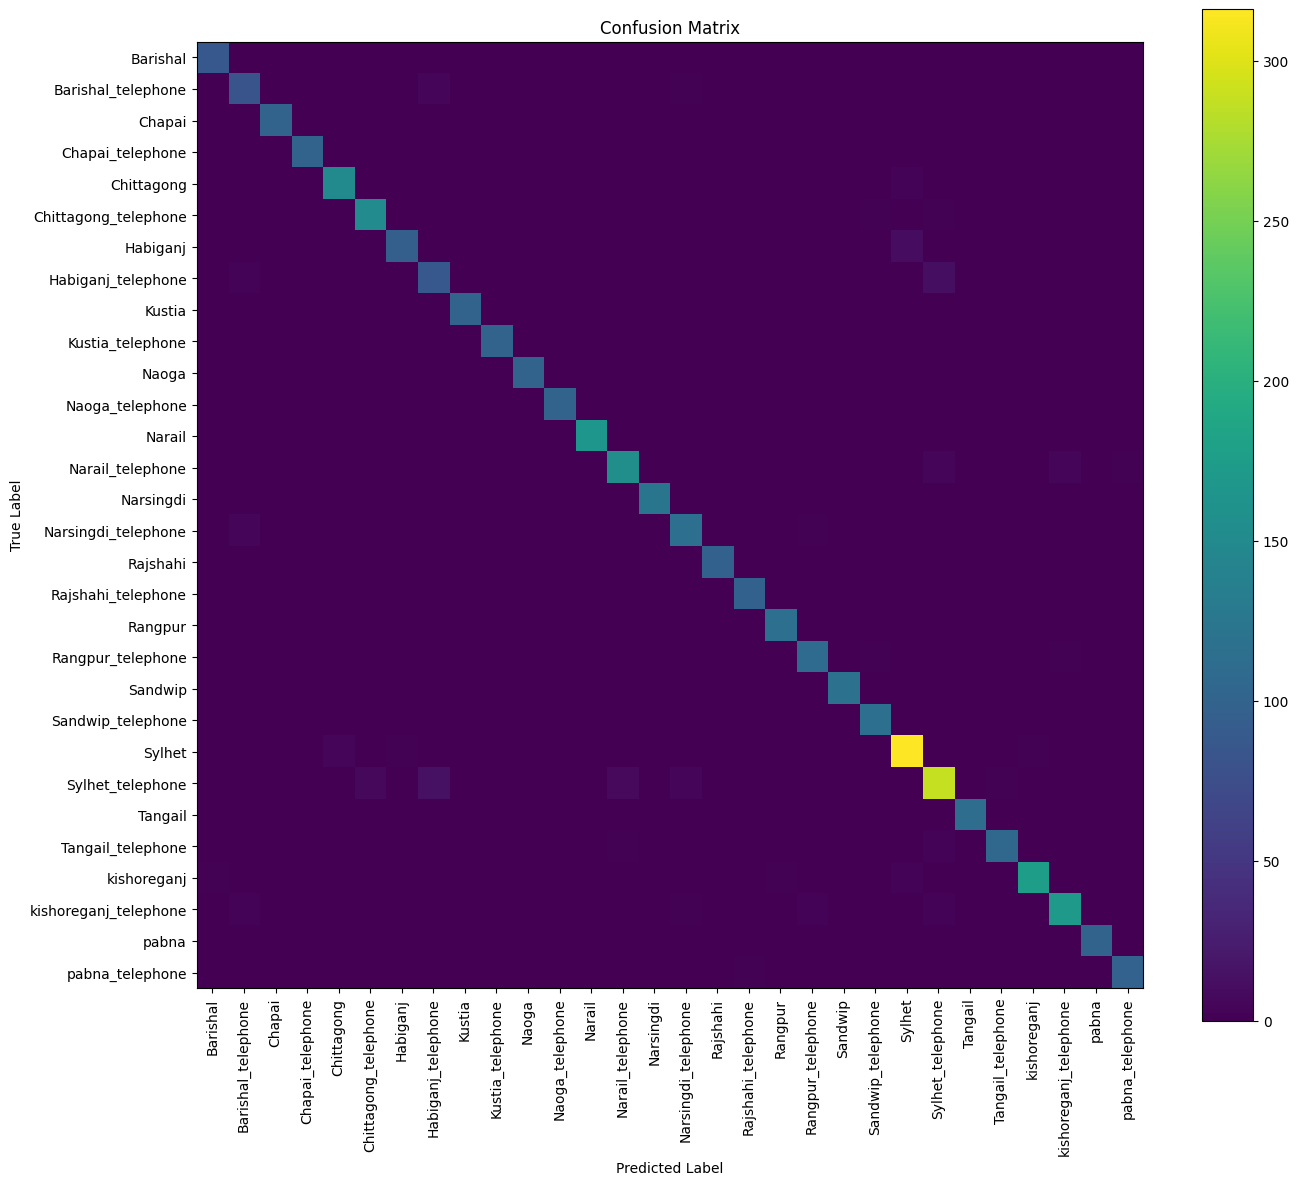

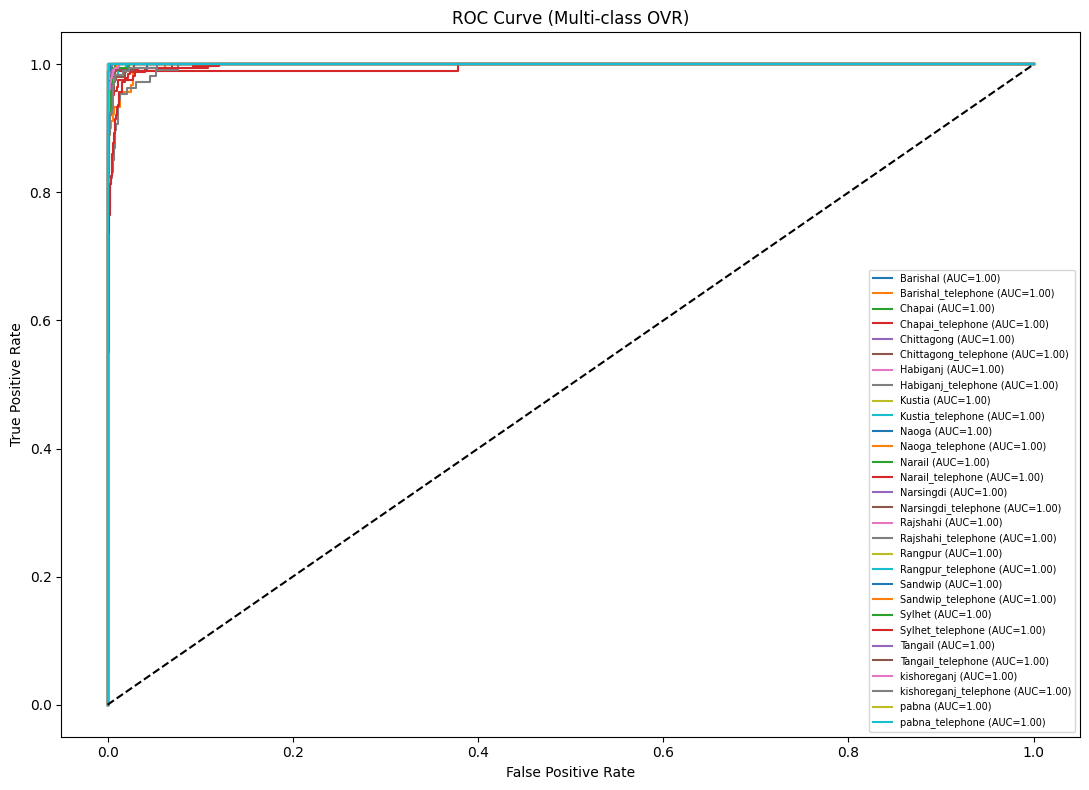

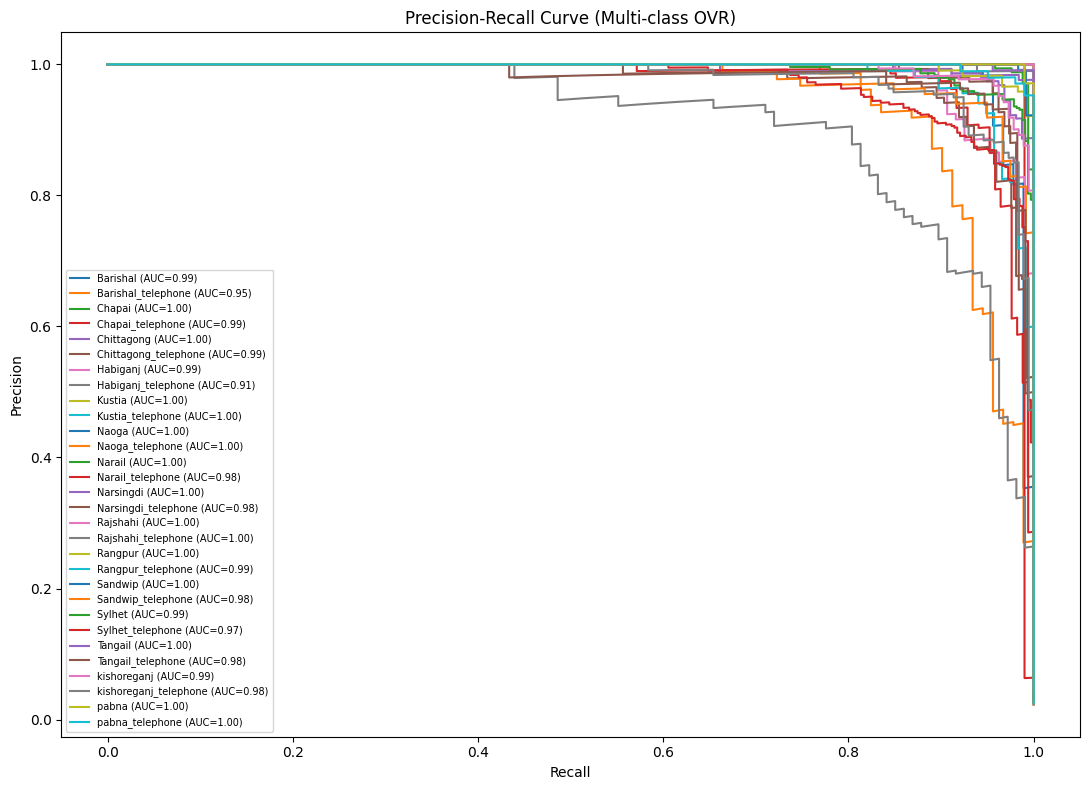

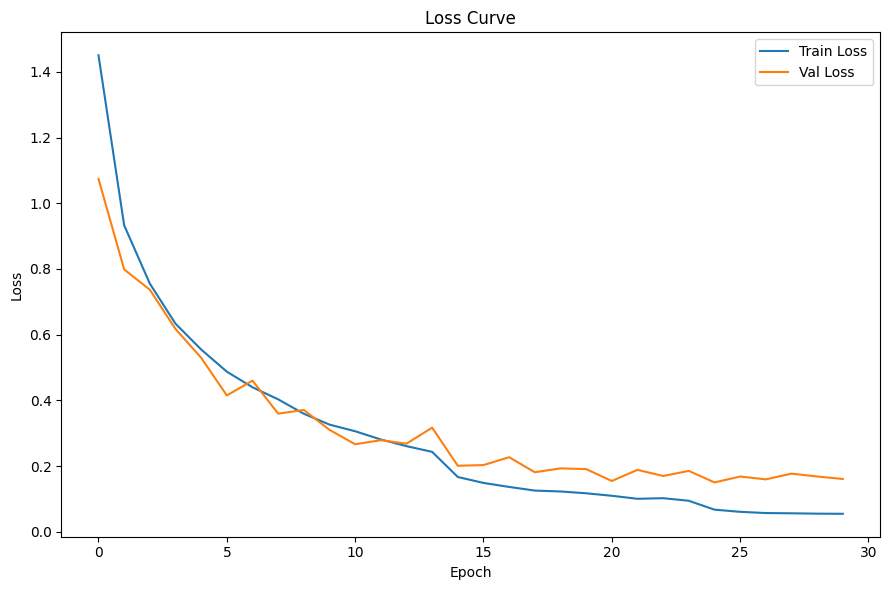

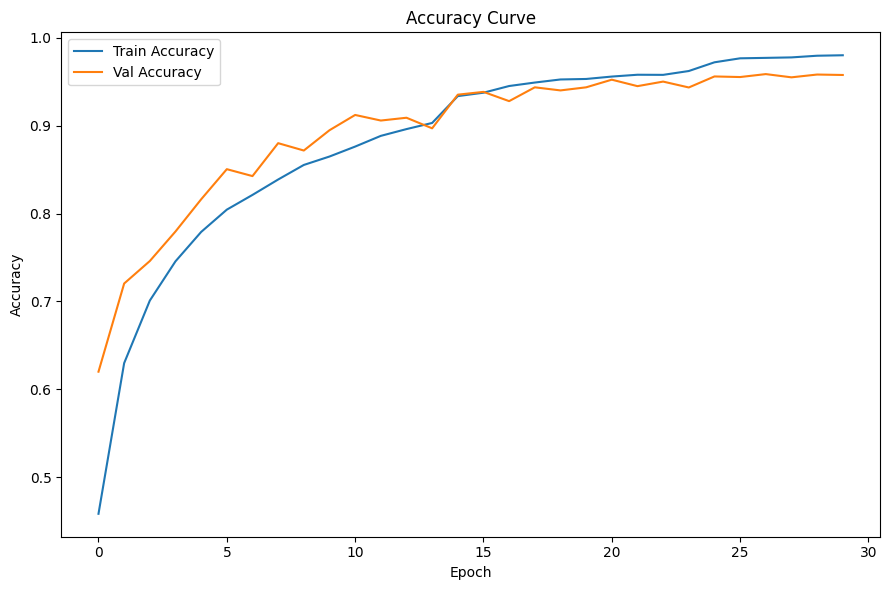

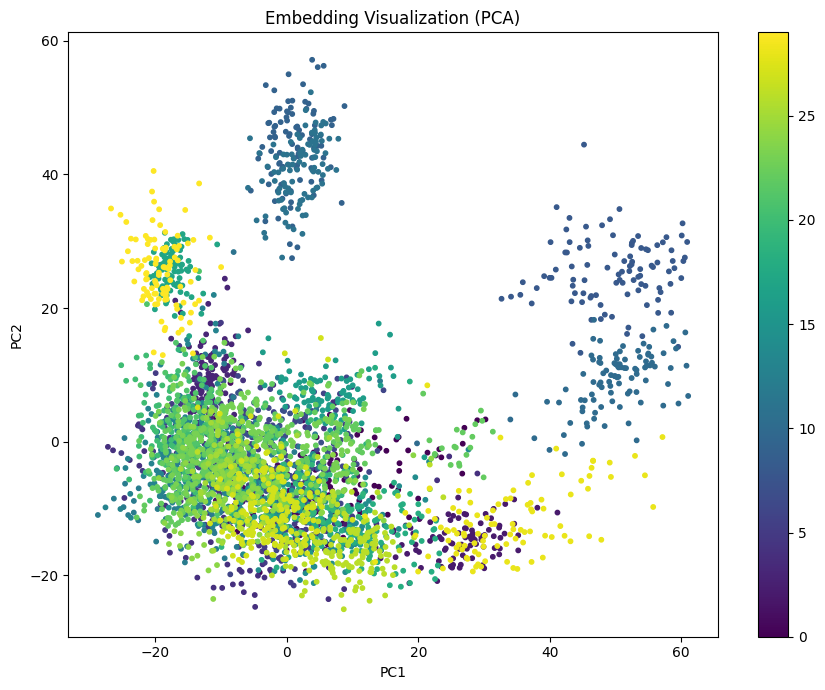

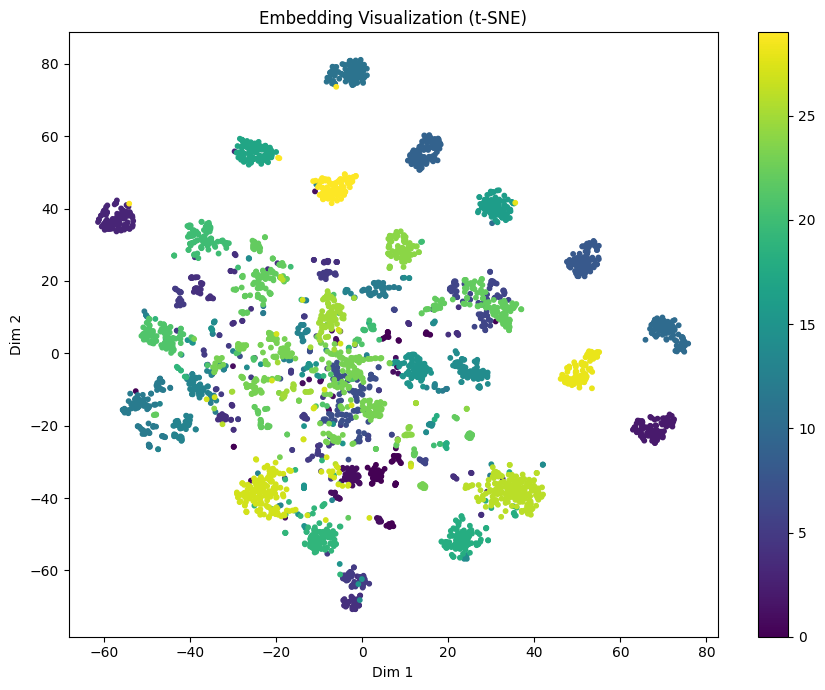

Plots saved to: D:\Real Vs Telephone_compressed\results


In [5]:
plot_all_results(
    y_true=y_true,
    y_pred=y_pred,
    probs_all=probs_all,
    class_names=CLASS_NAMES,
    train_losses=train_losses,
    val_losses=val_losses,
    train_accs=train_accs,
    val_accs=val_accs,
    embs=embs,
    emb_labels=emb_labels,
    out_dir="results",
    save=True,
    show=True,
    normalize_cm=False
)
